# Periodic Trends

Observations of the elemental properties reveal clear and known trends in the periodic table. It is desireable to test the applicability of statistical machine learning methods in predicting atomic properties.

Some possible metrics are:
1. Using regression to extrapolate the atomic radius of an unknown element using the electron configuration.
- This would demonstrate if the model is able to recognize the trend of decreasing atomic radius within a period, while increasing down a group.
2. Categorizing heavier metals according to their block in the periodic table using ionization energies
- The ionization energies should strongly correlate with the group as there should be a large spike in ionization energy when the nucleus is brought out of a full valence shell configuration.



All data is gathered from: https://www.kaggle.com/datasets/seansaliga/atomic-trends-hydrogen-to-radon/data

In [1]:
import pandas as pd

atomic_data = pd.read_csv('complete_dataset.csv')
#atomic_data = atomic_data.set_index('z')
atomic_data.tail(5)

import matplotlib.pyplot as plt
import numpy as np

In [2]:
atomic_data.columns

Index(['z', 'symbol', 'name', 'r_calculated', 'r_empirical', 'r_van_der',
       'r_covalent', 'r_covalent_triple', 'r_metallic', 'protons', 'neutrons',
       'max_n_level', '1s', '2s', '2p', '3s', '3p', '3d', '4s', '4p', '4d',
       '4f', '5s', '5p', '5d', '5f', '6s', '6p', 'ionization_1',
       'ionization_2', 'ionization_3', 'ionization_4', 'ionization_5',
       'ionization_6', 'ionization_7', 'ionization_8', 'ionization_9',
       'ionization_10', 'ionization_11', 'ionization_12', 'ionization_13',
       'ionization_14', 'ionization_15', 'ionization_16', 'ionization_17',
       'ionization_18', 'ionization_19', 'ionization_20', 'ionization_21',
       'ionization_22', 'ionization_23', 'ionization_24', 'ionization_25',
       'ionization_26', 'ionization_27', 'ionization_28', 'ionization_29',
       'ionization_30', 'n1_electrons', 'n2_electrons', 'n3_electrons',
       'n4_electrons', 'n5_electrons', 'n6_electrons'],
      dtype='object')

### Data Processing

It simplifies the process to only give information of the valence electrons, we can therefore reduce the columns containting the full information of the electron configuration, to the number of valence electrons

The columns involving number of 'n#' electrons gives the number of electrons in the valence shells

In [3]:
def find_valence_electrons(atomic_data): 
       ''' Returns number of electrons belonging to largest non-empty valence shell '''
       principal_quantum_number_electrons = ['n1_electrons', 'n2_electrons', 'n3_electrons',
              'n4_electrons', 'n5_electrons', 'n6_electrons']

       valence_electrons = []
       for _, atom in atomic_data.iterrows():
              prev_electrons = 0
              for pqne in principal_quantum_number_electrons[::-1]:
                     if prev_electrons:
                            break
                     if atom[pqne]:
                            prev_electrons = atom[pqne]
              valence_electrons.append(prev_electrons)
       atomic_data['valence_electrons'] = valence_electrons
       return atomic_data

atomic_data = find_valence_electrons(atomic_data)
atomic_data


,z,symbol,name,r_calculated,r_empirical,r_van_der,r_covalent,r_covalent_triple,r_metallic,protons,...,ionization_28,ionization_29,ionization_30,n1_electrons,n2_electrons,n3_electrons,n4_electrons,n5_electrons,n6_electrons,valence_electrons
0,1,H,hydrogen,53,25,120,32,0,0,1,...,0.0,0.0,0.0,1,0,0,0,0,0,1
1,2,He,helium,31,120,140,46,0,0,2,...,0.0,0.0,0.0,2,0,0,0,0,0,2
2,3,Li,lithium,167,145,182,133,0,152,3,...,0.0,0.0,0.0,2,1,0,0,0,0,1
3,4,Be,beryllium,112,105,153,102,85,112,4,...,0.0,0.0,0.0,2,2,0,0,0,0,2
4,5,B,boron,87,85,192,85,73,0,5,...,0.0,0.0,0.0,2,3,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,82,Pb,lead,154,180,202,144,137,0,82,...,0.0,0.0,0.0,2,8,18,32,18,4,4
82,83,Bi,bismuth,143,160,207,151,135,0,83,...,0.0,0.0,0.0,2,8,18,32,18,5,5
83,84,Po,polonium,135,190,197,145,129,0,84,...,0.0,0.0,0.0,2,8,18,32,18,6,6
84,85,At,astatine,127,0,202,147,138,0,85,...,0.0,0.0,0.0,2,8,18,32,18,7,7


##### Periodic block

To train the model to find the correct block, this category must be available to the model


A problem arises when filling the 4th period, namely the electrons do no fill the shells squentially, but rather can fill the 4s electron shell prior to filling 3d shells

In [4]:
def categorize_blocks(atomic_data):
    ''' Categorizes atoms into the corresponding block in the periodic table '''

    # Hard coded due to a number of exceptions to the 
    # aufbau rule for higher orbital configurations
    blocks = {  'f-block' : list(range(57,71)),
                'd-block' : list(range(71,81)) + list(range(39, 49)) + list(range(21, 31)),
                'p-block' : list(range(81,87)) + list(range(49, 55)) + list(range(31, 37)) 
                          + list(range(13,19)) + list(range(5,11)),
                's-block' : list(range(55,57)) + list(range(37,39)) + list(range(19,21)) 
                          + list(range(11,13)) + list(range(3,5)) + list(range(1,3))}
    for block in blocks:
        blocks[block].sort()
    categories = []
    for _, atom in atomic_data.iterrows():
        occupied_shells = ''
        for block in blocks:
            if atom['z'] in blocks[block]:
                categories.append(block.split('-')[0])
    atomic_data['blocks'] = categories
    return atomic_data


atomic_data=categorize_blocks(atomic_data)

### Prediction of atomic radii



The atomic radius is the measured size of an atom. By plotting 

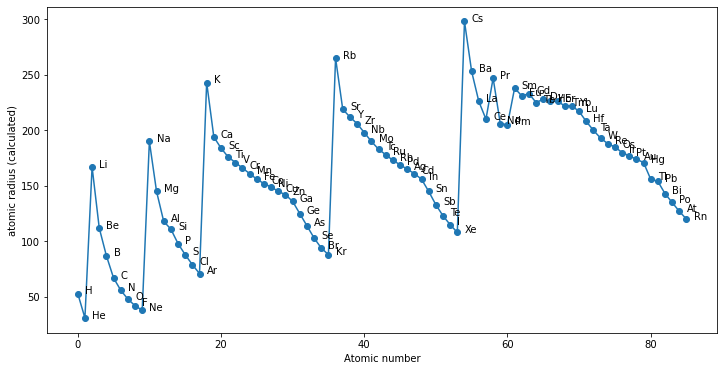

In [5]:
atomic_data.set_index('z')
fig,ax = plt.subplots(figsize=(12,6))
atomic_data['r_calculated'].plot(style='o-', xlabel='Atomic number', ylabel='atomic radius (calculated)')
for index, atom in atomic_data.iterrows():
    ax.annotate(atom['symbol'], (index+1, atom['r_calculated']))


It can be seen that there is a clear increase in size with increasing principal quantum number, and a contraction with the increase of electrons within a period.

We wish to see how well this trend can be captured by using statistical machine learning models. For this we can employ the sklearn module.

Mean absolute error:  25.40909090909091


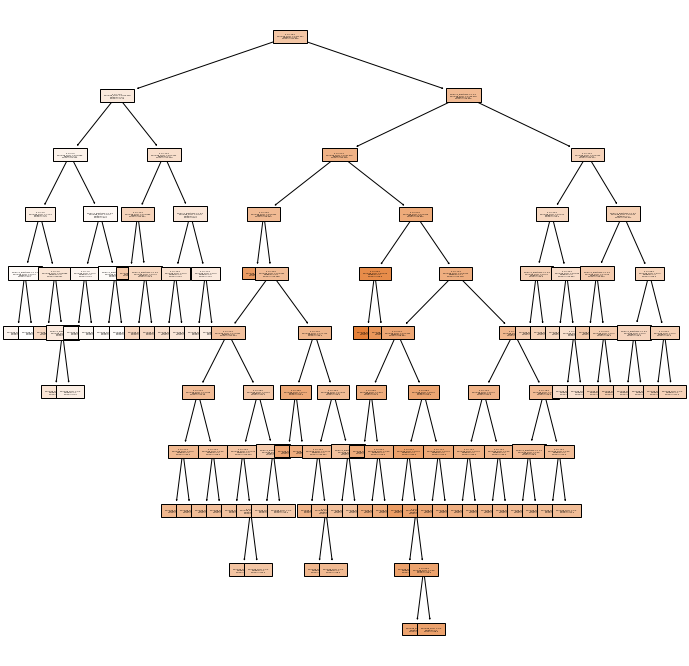

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
features = ['z', 'valence_electrons']
y = atomic_data.r_calculated
X = atomic_data[features]

radius_model = DecisionTreeRegressor(random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=1)
radius_model.fit(X_train,y_train)

prediction = radius_model.predict(X_val)
print('Mean absolute error: ',mean_absolute_error(prediction, y_val))
#print(sklearn.tree.export_text(radius_model))
plt.figure(figsize=(12,12))
_ = sklearn.tree.plot_tree(radius_model, feature_names=features, filled=True, fontsize=2)
#Uncomment to save a png of the tree
#plt.savefig('tree_high_dpi', dpi=1000)


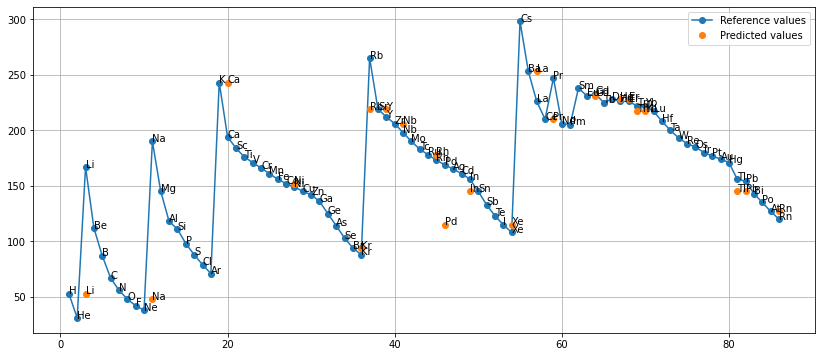

In [7]:
def plot_prediction(atomic_data, predictions, X_val):
    fig, ax = plt.subplots(figsize=(14,6))
    prediction_index = []
    prediction_val = []
    prediction_labels = []
    for i in range(len(prediction)):
        prediction_index.append(X_val.iloc[i]['z'])
        prediction_val.append(prediction[i])
    reference_x , reference_y = [], []
    for index, atom in atomic_data.iterrows():
        reference_x.append(atom['z'])
        reference_y.append(atom['r_calculated'])
    ax.plot(reference_x, reference_y, 'o-', label='Reference values')
    ax.plot(prediction_index, prediction_val, 'o', label='Predicted values')
    for index, atom in atomic_data.iterrows():
        ax.annotate(atom['symbol'], (index+1, atom['r_calculated']))
    for i in range(len(prediction)):
        atomic_symbol=atomic_data.loc[atomic_data['z']==X_val.iloc[i]['z']]['symbol']
        ax.annotate(atomic_symbol.iloc[0], (X_val.iloc[i]['z'], prediction[i]))
    
    ax.grid()
    ax.legend()

plot_prediction(atomic_data, prediction, X_val)

It can be seen that the model does not correctly predict the expansion expected from alkaline metals, in the case of lithium and sodium, this may be due to these atoms not being included in the training data and thus being influenced too much by surrounding atoms. 

Calsium too is predicted too highly, the model perhaps overcompensating for the peak caused by potassium. 

Palladium too is an apparent outlier and it does not readily appear to be a plausible physical interpretation of this. It may be the model incorrectly predict a too sharp contraction and is expecting there to be another peak in that area. 

### Categorization of periodic block



The periodic blocks are caracterized by their valence electrons and the orbitals they occupy.

Below is a plotting of the first three ionization energies

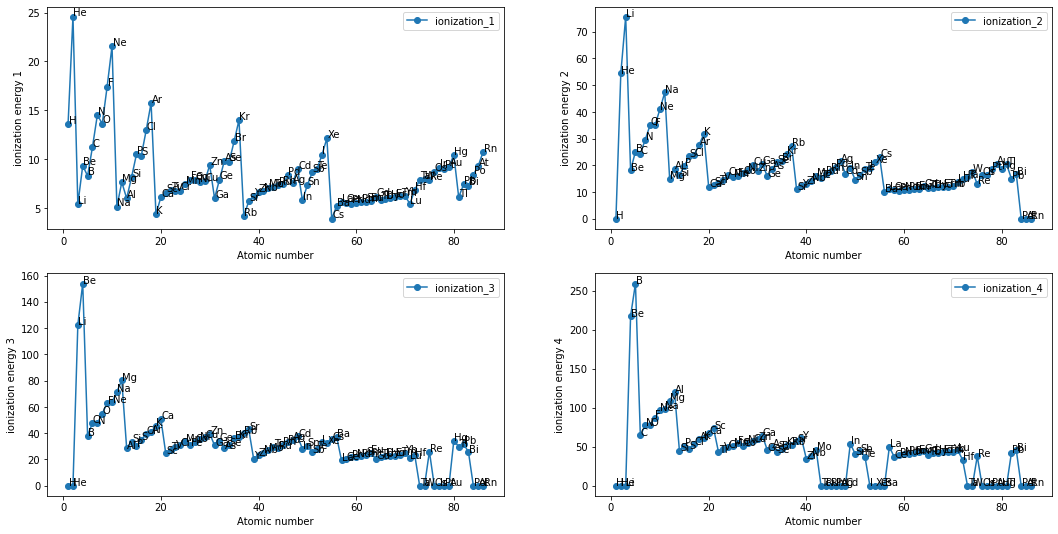

In [8]:
fig,axs = plt.subplots(2,2, figsize=(18,9))
axs = axs.reshape(4,1)
for i in range(1,5):
    atomic_data.plot(x='z', y=f'ionization_{i}', style='o-', xlabel='Atomic number', ylabel=f'ionization energy {i}', ax=(axs[i-1][0]))
    for index, atom in atomic_data.iterrows():
        axs[i-1][0].annotate(atom['symbol'], (atom['z']+0.1, atom[f'ionization_{i}']+0.1))


It is noted that for higher atomic numbers, espcecially greater than 30, that there is missing information about the higher ionization energies.
We can therefore limit ourselves to the lowest 3 ionizations. 

As all the noble gasses have full valence shells, the first ionization energy is expected to be large. All the noble gasses are in the p block, except helium, this should give a good indication to the model. Helium and hydrogen do not really fit neatly into the periodic groups and might be misclassified by the model. 

The elements of the s-block enter noble gas configuration after the removal of the first or second electron, this is why the period 1 and 2 elements have destinct ionization energies in the second and third ionizations respectively. 

Finding the f-block, from the p-block may prove difficult as this is a less rigid destinction than between s and p block elements

In [9]:
from sklearn.tree import DecisionTreeClassifier

features = ['z', 'valence_electrons', 'ionization_1',
       'ionization_2', 'ionization_3',]
y = atomic_data.blocks
X = atomic_data[features]

block_classifier = DecisionTreeClassifier(random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=1)
block_classifier.fit(X_train,y_train)
prediction = block_classifier.predict(X_val)

[[3 0 1 1]
 [0 6 0 1]
 [0 0 6 0]
 [0 0 0 4]]


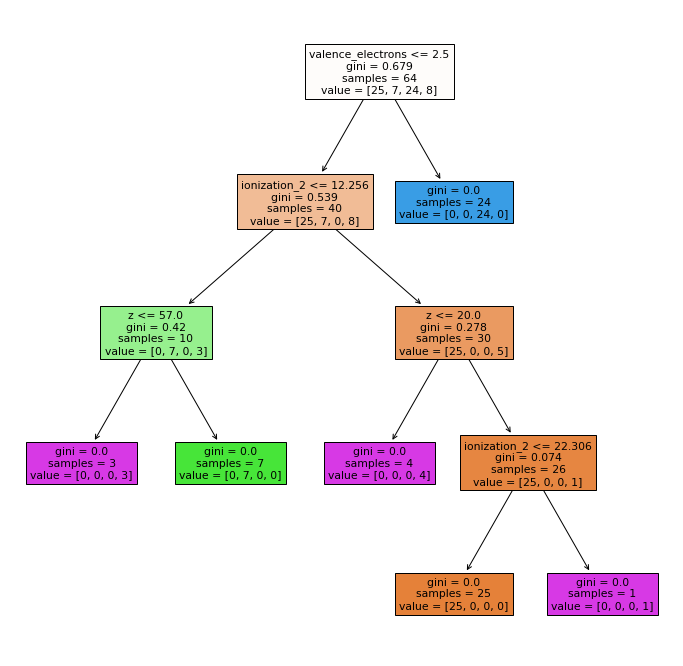

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(confusion_matrix(y_val, prediction))
plt.figure(figsize=(12,12))
_ = sklearn.tree.plot_tree(block_classifier, feature_names=features, filled=True)



It can be seen that, this desicion tree simply eliminates the s block by correctly removing nuclei with less than two electrons and that only the second ionization energy is used to classify the block of the other atoms, showing that the trend of filling the s orbital first is captured by the model. Further the low second ionization energies of the f-block elements is used to destinguish the p-block elements. 

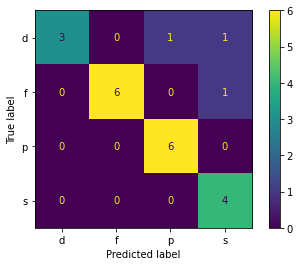

In [11]:
ConfusionMatrixDisplay(confusion_matrix(y_val, prediction), display_labels=['d', 'f', 'p', 's']).plot()

In [12]:
print(y_val.unique())
print(y_val.value_counts())
print(type(y_val))

['d' 's' 'p' 'f']
f    7
p    6
d    5
s    4
Name: blocks, dtype: int64
<class 'pandas.core.series.Series'>


By removing the valence electrons from the features, the model will have a lot more difficulty determining the distribution of labels

[[4 0 1 0]
 [1 0 5 1]
 [0 0 5 1]
 [0 0 1 3]]
['d' 's' 'p' 'f']
f    7
p    6
d    5
s    4
Name: blocks, dtype: int64
<class 'pandas.core.series.Series'>


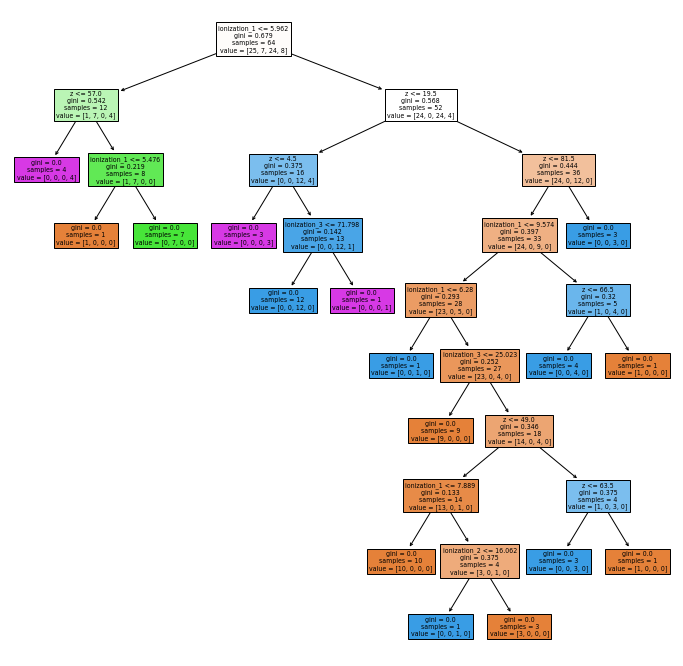

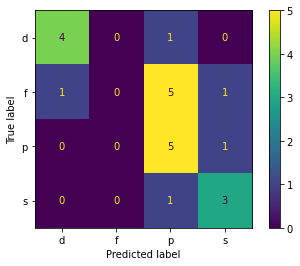

In [13]:
features = ['z', 'ionization_1',
       'ionization_2', 'ionization_3',]
y = atomic_data.blocks
X = atomic_data[features]

block_classifier = DecisionTreeClassifier(random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=1)
block_classifier.fit(X_train,y_train)
prediction = block_classifier.predict(X_val)
print(confusion_matrix(y_val, prediction))
plt.figure(figsize=(12,12))
_ = sklearn.tree.plot_tree(block_classifier, feature_names=features, filled=True)
ConfusionMatrixDisplay(confusion_matrix(y_val, prediction), display_labels=['d', 'f', 'p', 's']).plot()
print(y_val.unique())
print(y_val.value_counts())
print(type(y_val))


It is seen that now the model is much more complex but still fails to correctly predict any of the f-block elements, instead labeling them as p-block elements. 